## Introduction to Natural Language Processing
[**CC-BY-NC-SA**](https://creativecommons.org/licenses/by-nc-sa/4.0/deed.en)<br/>
Prof. Dr. Annemarie Friedrich<br/>
Faculty of Applied Computer Science, University of Augsburg<br/>
Date: **SS 2025**

# 5.+ 6. Homework
## Training and Evaluating a Logistic Regression Classifier

In this homework, we will:
* implement tf.idf-based features to represent texts
* train a multinomial logistic regression classifier using scikit-learn
* tune our classifier based on a validation set
* observe the learning curves
* report final results on a pre-defined test set

## Requirements
Hand in a 2-page report (upload into the Homework Submission folder in the folder `06 Gradient Descent` answering the questions marked below. Appendices are not allowed. All tables, figures (and potentially references) must occur within the 3 pages.
For this submission, you must use the [ACL Style Templates](https://github.com/acl-org/acl-style-files) (available in Latex and for MS Word).

❗Upload your report in PDF format.

In [49]:
# Installations (remove these two lines and install packages if you work locally)
!pip install --user -U nltk
!pip install -U datasets

# Imports: You may use exactly these imports in your code below.
import pprint as pp
from collections import defaultdict
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt_tab') # Downlad the Punkt sentence segmentation algorithm
nltk.download('stopwords') # English stopwords
from nltk.corpus import stopwords
stopwords = set(stopwords.words("english"))
import datasets
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
import string
punctuations = set([p for p in string.punctuation])
punctuations.add('’')
punctuations.add('``')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 20 Newsgroup Dataset

In this homework, we will work with the [20 Newsgroups dataset](http://qwone.com/~jason/20Newsgroups/). Go to the original website of the dataset and read about the dataset.

❓In your report, _briefly_ describe the dataset. What is the goal of the classification task? (Is this a genre or a topic classification task?) Optional: report how long the news items are in number of sentences, tokens, ...

In [50]:
# Load the 20 Newsgroup dataset: a training and a test set are provided
train_data = load_dataset('rungalileo/20_Newsgroups_Fixed', split="train")
test_data = load_dataset('rungalileo/20_Newsgroups_Fixed', split="test")

def create_simpler_object(dataset):
  """Creates a simple list of dictionaries from the original datasets. Dataset
  object (for simplicity reasons for now). Removes instances that do not have
  a label. """
  dataset_simple = []
  for instance in dataset:
    if instance["label"] != "None" and instance["label"] is not None:
      dataset_simple.append(instance)
  return dataset_simple

train_data = create_simpler_object(train_data)
test_data = create_simpler_object(test_data)

In [51]:
# It's always a good idea to inspect your data:
pp.pprint(train_data[0])

for k in train_data[3]:
  print(k, train_data[3][k])

inst_count = 0
sent_count = 0
token_count = 0

for i in train_data:
  inst_count += 1
  sent_count += len(sent_tokenize(i['text']))
  token_count += len(word_tokenize(i['text']))
for i in test_data:
  inst_count += 1
  sent_count += len(sent_tokenize(i['text']))
  token_count += len(word_tokenize(i['text']))

print(f"Number of instances: {inst_count}.")
print(f"Number of sentences in whole corpus: {sent_count}.")
print(f"AvgSentences per instance: {sent_count/inst_count}.")
print(f"Number of tokens in whole corpus: {token_count}.")
print(f"AvgTokens per instance: {token_count/inst_count}.")



{'id': 0,
 'label': 'rec.autos',
 'text': 'I was wondering if anyone out there could enlighten me on this car I '
         'saw\n'
         'the other day. It was a 2-door sports car, looked to be from the '
         'late 60s/\n'
         'early 70s. It was called a Bricklin. The doors were really small. In '
         'addition,\n'
         'the front bumper was separate from the rest of the body. This is \n'
         'all I know. If anyone can tellme a model name, engine specs, years\n'
         'of production, where this car is made, history, or whatever info '
         'you\n'
         'have on this funky looking car, please e-mail.'}
id 3
text 
Do you have Weitek's address/phone number?  I'd like to get some information
about this chip.

label comp.graphics
Number of instances: 17683.
Number of sentences in whole corpus: 207802.
AvgSentences per instance: 11.751512752361025.
Number of tokens in whole corpus: 4762051.
AvgTokens per instance: 269.30108013346154.


The 20 Newsgroups dataset comes with a training split and a test split. For our experiment here, we want to work cleanly and avoid optimizing our model for the test set. Hence, we split off a __validation set__ from the training data.

❓How many instances to the training set, the validation set, and the test have, respectively? Report these numbers in a small table in your report.

In [52]:
# Let's split off a validation set from the training sets
val_data = train_data[int(0.8*len(train_data)):]
train_data = train_data[:int(0.8*len(train_data))]

# Lengths (in number of instances) of the train, validation, and test splits
print("Instances in train data:", len(train_data))
print("Instances in val data:", len(val_data))
print("Instances in test data:", len(test_data))

Instances in train data: 8531
Instances in val data: 2133
Instances in test data: 7019


Next, write a function `get_label_counts` that takes a set of instances as input and returns a dictionary that contains the number of instances per label. Use this function to compute three dictionaries with label counts, one for each datasplit (train, val, test).

In [53]:
def get_label_counts(data):
  label_counts = defaultdict(int)
  for i in data:
    label_counts[i['label']] += 1
  #uncomment for a peek on the counts
  #pp.pprint(label_counts)
  return label_counts

label_counts_train = None
label_counts_val = None
label_counts_test = None

# Solution
label_counts_train = get_label_counts(train_data)
label_counts_val = get_label_counts(val_data)
label_counts_test = get_label_counts(test_data)



The following code plots the label distributions of the training splits as a grouped barplot.

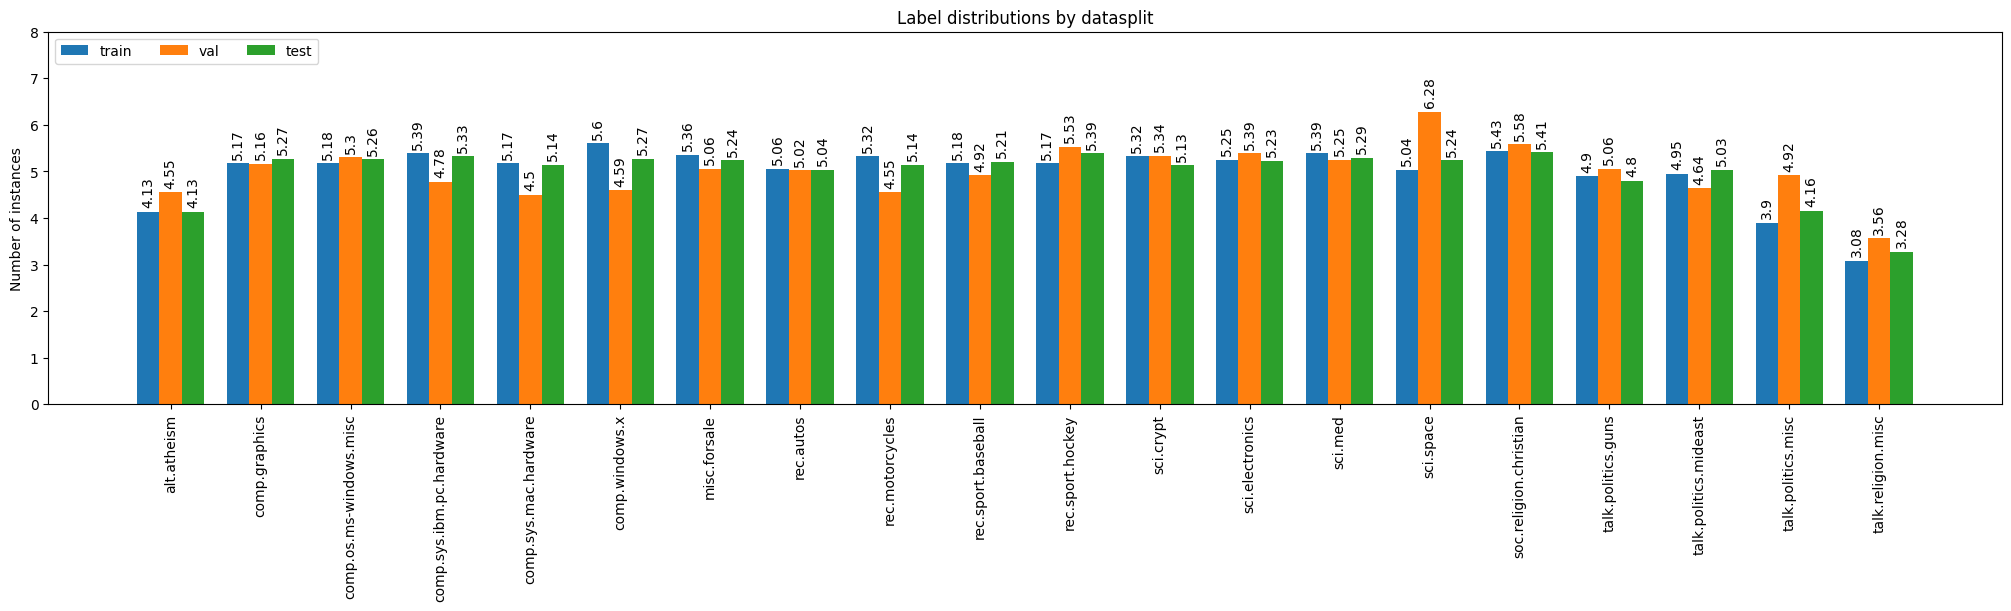

In [54]:
# sort values by their keys (alphabetically)
#sorted_items = sorted(list(label_counts_train.items()), reverse=True)
labels = sorted(label_counts_train.keys())
train_values = np.array([label_counts_train[l] for l in labels])
val_values = np.array([label_counts_val[l] for l in labels])
test_values = np.array([label_counts_test[l] for l in labels])

# normalize so it's meaningful to compare the distributions
train_values = train_values * 100 / np.sum(train_values)
val_values = val_values * 100 / np.sum(val_values)
test_values = test_values * 100 / np.sum(test_values)

train_values = [round(v, 2) for v in train_values]
val_values = [round(v, 2) for v in val_values]
test_values = [round(v, 2) for v in test_values]

values = {
    "train" : train_values,
    "val"   : val_values,
    "test"  : test_values
}

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(20,6))

for datasplit, value in values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, value, width, label=datasplit)
    ax.bar_label(rects, padding=3, rotation="vertical")
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of instances')
ax.set_title('Label distributions by datasplit')
ax.set_xticks(x + width, labels, rotation="vertical")
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 8)

plt.show()

❓Include the label distribution image in your report. Hint: in latex, you can achieve wide figures using:

```
\begin{figure*}
...
\end{figure*}
```

_Briefly_ discuss the following questions: Are the instances distributed equally over the labels? Are the label distributions of training, validation, and test split comparable?


## Tokenization

Your next task is to tokenize the texts into words using the Punkt algorithm from `nltk` (see imports above).

In [55]:
def tokenize(dataset):
  """
  Take a dataset (train, validation, or test) and tokenizes the text.
  Adds a key "tokens" to each instance dict that contains the word-tokenized text.
  Hint: the following code will be easier if you just use one list here that contains
  the tokens of all sentences.
  Returns the update dataset.
  """
  # each dataset is a list of dictionaries
  #for i in range(len(dataset)):
  #  tokens = word_tokenize(dataset[i]['text'])
  #  dataset[i].update({"tokens": tokens})
  for i in dataset:
    tokens = word_tokenize(i['text'])
    i.update({"tokens": tokens})
  return dataset

# Tokenize all datasplits
train_data = tokenize(train_data)
pp.pprint(train_data[3])
test_data = tokenize(test_data)
pp.pprint(test_data[3])
val_data = tokenize(val_data)
pp.pprint(val_data[3])

{'id': 3,
 'label': 'comp.graphics',
 'text': '\n'
         "Do you have Weitek's address/phone number?  I'd like to get some "
         'information\n'
         'about this chip.\n',
 'tokens': ['Do',
            'you',
            'have',
            'Weitek',
            "'s",
            'address/phone',
            'number',
            '?',
            'I',
            "'d",
            'like',
            'to',
            'get',
            'some',
            'information',
            'about',
            'this',
            'chip',
            '.']}
{'id': 4,
 'label': 'talk.religion.misc',
 'text': '\n'
         "I've just spent two solid months arguing that no such thing as an\n"
         'objective moral system exists.',
 'tokens': ['I',
            "'ve",
            'just',
            'spent',
            'two',
            'solid',
            'months',
            'arguing',
            'that',
            'no',
            'such',
            'thing',
            'a

## Vocabulary

We compute the __vocabulary__, i.e., the set of words that is used, from the training set.

❓ Why do we not include the validation or test set when computing the vocabulary for our classifier?

❓In your report, first report the total number of different "words" (according to the tokenizer) in the training set.
Then, remove all words that are either stopwords (using the ste of stopwords imported above), that are a punctuation character or that occur less than 200 times in the training set. Report the size of this filtered vocabulary. We will work with this filtered version from now on.

In [56]:
# What is the full vocabulary of the training set?

# vocab is a set i.e. no repetition
vocab = set()

# each dataset is a list of dictionaries
for i in range(len(train_data)):
  for t in train_data[i]['tokens']:
    # we attempt to add every token found
    # if already in set, it doesn't get added again anyway
    vocab.add(t)

print(f"Length of unpurged vocab:\t{len(vocab)}.")

# Remove all stopwords...
for s in stopwords:
  vocab.discard(s)
print(f"\t\t- stopwords =\t{len(vocab)}.")

# Remove all punctuation symbols...
for p in punctuations:
  vocab.discard(p)
print(f"\t\t- punctuations ={len(vocab)}.")

# Remove all words that occur less than 200 times in the training set
# -- Go through set, count occurrences of each token
word_counts = defaultdict(int)
for i in train_data:
  for t in i['tokens']:
    word_counts[t] += 1
#uncomment for a peek on the counts
#pp.pprint(word_counts)

# -- Go through word_counts, if count < 200, remove word from set
t = 0

for wc in word_counts:
  if(word_counts[wc] < 200):
    vocab.discard(wc)
    t += 1
    #uncomment for a peek on which words are being removed
    #print(f"{t}:Found {wc} with count = {word_counts[wc]}. Removed.")

print(f"\t\t-{t} words happening under 200 times ={len(vocab)}.")


Length of unpurged vocab:	138436.
		- stopwords =	138295.
		- punctuations =138263.
		-137483 words happening under 200 times =804.


### Inverse Document Frequency
Next, we compute the inverse document frequency of each vocabulary term $t$ as follows:

$\displaystyle idf(t) = log[\frac{n}{df(t)}] + 1 $

Here, $n$ is the total number of documents (in the training set), and $df(t)$ is in how many documents the term (word) $t$ occurs.
Use `math.log(x)` to compute the inverse document frequency for all vocabulary items.

❓In your report, list a few terms with a _high_ and a few terms with a _low_ inverse document frequency. Which terms are more/less common?

In [57]:
doc_count = len(train_data)
print(f"Number of documents (for calculating inv. doc freq.): {doc_count}")

vocab_stats = {}
vocab_dfs = []
vocab_idf = []

# Compute the document frequency (df) for each word in the vocabulary from the training data
# vocab is a set
for v in vocab:
  count = 0
  # train_data is a list of dictionaries
  for doc in train_data:
    if(v in doc['text']):
      count += 1
  d = {'df': count}
  vocab_stats.update({v : d})
  vocab_dfs.append((count,v))

# Compute the inverse document frequency (idf) for each word in the vocabulary
for v in vocab:
  idf = math.log(doc_count/vocab_stats[v]['df']) + 1
  vocab_stats[v].update({'idf': idf})
  vocab_idf.append((idf,v))


# vocab_stats is a dict of dicts
# the key is a word (from vocab)
# each value is a dict with keys 'df' and 'idf'
print(f"Example of entry in the 'vocab_stats' dict:")
print(f"'yet':{vocab_stats['yet']}")

# vocab_dfs and vocab_idf are lists containing tupels of (df or idf, word).
# we sort the lists and print the first and last elements of each list.
vocab_dfs.sort()
vocab_idf.sort()

print(f"First ten (absolute)dfs:")
pp.pprint(f"{vocab_dfs[0:10]}")
print(f"Last ten:")
pp.pprint(f"{vocab_dfs[-10:]}")
print()
print(f"First ten idfs:")
pp.pprint(f"{vocab_idf[0:10]}")
print(f"Last ten:")
pp.pprint(f"{vocab_idf[-10:]}")







Number of documents (for calculating inv. doc freq.): 8531
Example of entry in the 'vocab_stats' dict:
'yet':{'df': 387, 'idf': 4.093037173878913}
First ten (absolute)dfs:
("[(5, '55.0'), (8, '2DI'), (10, 'A86'), (10, 'GIZ'), (11, '7EY'), (11, "
 "'P\\\\/'), (11, 'Q,3'), (12, '/3T'), (12, '0T-'), (12, 'B8F')]")
Last ten:
("[(4628, 'M'), (4632, 'x'), (4850, 'C'), (5572, 'S'), (5729, 'A'), (5863, "
 "'us'), (6052, 'ca'), (6298, 'T'), (7342, 'I'), (8502, 'n')]")

First ten idfs:
("[(1.0034051579899594, 'n'), (1.1500953028519152, 'I'), (1.3034744652477248, "
 "'T'), (1.3433177920004482, 'ca'), (1.3750451699444797, 'us'), "
 "(1.398165592500117, 'A'), (1.4259525320089983, 'S'), (1.564727882977166, "
 "'C'), (1.6107178476558635, 'x'), (1.6115817785951276, 'M')]")
Last ten:
("[(7.566555217120694, 'B8F'), (7.566555217120694, 'BHJ'), (7.566555217120694, "
 "'PL+'), (7.653566594110324, '7EY'), (7.653566594110324, 'P\\\\/'), "
 "(7.653566594110324, 'Q,3'), (7.748876773914649, 'A86'), (7.748876773

Write a function `set_tfidf(data_set)` that takes a datasplit as input and adds an entry with the key `tf.idf` to each instance. This entry is a vector whose dimensions correspond to the vocabulary items in some fixed (e.g., alphabetical) order. The values of each entry of this vector are the tf.idf values fort he respective vocabulary word. This is computed as:

$tf.idf(t, d) = tf(t, d) * idf(t)$

The _term frequency_ $tf(t, d)$ is simply how often the word occurs in the particular instance. You can look up the idf value of the term in the dictionary you have created in the last step. You multiply them together.
Call this function on the training, test, and evaluation data.

In [58]:
# Adds a tf.idf vector to each instance dictionary using the key "tf.idf".
# Returns the updated data_set.
def set_tfidf(data_set):
  # data_set is a list of dicts, each cont keys 'id','label','text','tokens'
  vocab_list = list(vocab_stats.keys())
  # we sort the list of vocab to give consistent structure to our new feature
  vocab_list.sort()

  for i in data_set:
    # each instance in data_set gets a new feature: a vector...
    tf_idfs = []

    # ... that has the length of the vocabulary
    for v in vocab_list:
      # how many times does this v appear in this instance's text?
      tf = i['tokens'].count(v)
      # "use the df from the train data to set all the tf.idf values"
      # All values in vocab_stats were calculated using
      # the df from the train_data in the previous cell
      tf_idf = tf * vocab_stats[v]['idf']
      tf_idfs.append(tf_idf)
    i.update({'tf.idf':tf_idfs})
  return data_set

train_data = set_tfidf(train_data)
val_data = set_tfidf(val_data)
test_data = set_tfidf(test_data)


## Mapping class labels to indices
We have now prepared the feature representations of all instances. Next, we need to encode the labels of each instance. In the dataset given above, they are encoded as strings (take a look at the field "label" of an instance). We can map them to integer values as follows:
1. Create an alphabetically sorted list of the labels.
2. Create a dictionary that maps each string class label to an integer. Hint: the `enumerate` function can be helpful here, but you can also use standard `for` loops.
3. Implement the function  `set_class_idx` below that takes a dataset and the indes from step 2 as input. For output see comment string below.

In [59]:
labels = sorted(labels)
label2idx = {l:i for i, l in enumerate(labels)}
idx2label = {i:l for i, l in enumerate(labels)}

def set_class_idx(data_set, label2idx):
  """
  Takes a dataset and a dictionary that maps label strings to integer indexes.
  Adds an entry for the key "classIdx" to each instance that encodes the class label as an integer.
  """
  for i in data_set:
    # set the class index for each instance
    l = i['label']
    i.update({ 'classIdx' : label2idx[l] })

set_class_idx(train_data, label2idx)
set_class_idx(val_data, label2idx)
set_class_idx(test_data, label2idx)

### Logistic Regression

We will use scikit-learn's implementation of logistic regression classifier. (In fact, we will use its Stochastic Gradient Classifier (SGDClassifier) with a configuration that corresponds to a logistic regression classifier. Scikit-learn also has a LogisticRegression classifier, but this implementation uses a different optimizer.

Now we have prepared the data, each instance is presented as a feature vector of td.idf values, and encoded the label as a class idx. Yet, the overall data structures of the datasplits are still lists. Scikit learn expects matrices and vectors as its input (or at least lists or multi-dimensional lists with only numeric values, such that it can create matrices and vectors from the inputs).
For each datasplit:
* We create one vector with all the gold labels (using the "classIdx" entries from above). In the scikit-learn documentation, this vector is called y.
* We create one matrix with all the feature representations of the instances. The first dimension (~ rows) are the instances, the second dimension (~ columns) are the features (here: each feature dimension corresponds to one vocabulary word). The values in the instance representations matrix are the "tf.idf" values from above. The scikit-learn documentation calls this matrix that contains all the numeric representations of the training data instances X.

Implement the `vectorize_data` function below.


In [60]:
def vectorize_data(data_set):
  y = [i['label'] for i in data_set]
  X = [i['tf.idf'] for i in data_set]
  return X, y

train_data_X, train_data_y = vectorize_data(train_data)
test_data_X, test_data_y = vectorize_data(test_data)
val_data_X, val_data_y = vectorize_data(val_data)

### Learning / Optimization and Hyperparameter Tuning

Now, we are ready to train our logistic regression classifier. Compare to the spelled-out example of binary logistic regression that you have enountered in the in-class activity, using scikit-learn's implementation is surprisingly little code (though not as configurable).

```
clf = SGDClassifier(random_state=0, max_iter=10, warm_start=True)
```

This line creates a classifer object of the [SGDClassifier](https://scikit-learn.org/stable/modules/sgd.html) class.
We perform the training using our training data in the format X, y by calling the function `fit`.

The `max_iter` parameter defines how many _epochs_ (passes through the dataset) the optimizer will make at most (if it does not converge). The parameter `warm_start=True` means that the model will keep its current parameter values and further optimize them, even if we re-start training by calling `fit` again on the classifier object.

Generally, it's a bad idea to ignore warnings.
I'll do it here because I am interrupting the learning on purpose and hence the "ConvergenceWarning" (that the classifier isn't done training) is fine with me.

❓In the code below, compute the accuracy of the classifier for the training and for the validation set after each epoch of training and add the values to `performance_values_train` and to `performance_values_val`. We will use these lists to plot learning curves in the next step.
Hint: Check out the [API of SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier) - it contains a function that will easily compute this for you if called correctly.

In [61]:
from sklearn.exceptions import ConvergenceWarning

def train_classifier(train_data_X, train_data_y, learning_rate, num_epochs):
  steps = []
  performance_values_train = []
  performance_values_val = []

  clf = SGDClassifier(random_state=0, max_iter=1, warm_start=True, loss="log_loss", learning_rate="constant", eta0=learning_rate)
  # max_iter = 1: when calling fit(), the model will be trained for at most 1 steps

  for train_step in range(num_epochs): # we will pass through the entire (shuffled) dataset this many times

    clf.fit(train_data_X, train_data_y) # train the model using the training data (for max_iter=10 steps)

    # Compute the validation and training accuracy
    val_acc = clf.score(val_data_X, val_data_y)
    train_acc = clf.score(train_data_X, train_data_y)

    steps.append(train_step+1)
    performance_values_train.append(train_acc)
    performance_values_val.append(val_acc)
  return clf, steps, performance_values_train, performance_values_val

# For your experiments, adapt the parameters here.
num_epochs = 15
learning_rate = 0.0001
clf, steps, performance_values_train, performance_values_val = train_classifier(train_data_X, train_data_y, learning_rate, num_epochs)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic

__When to stop the training?__

Ideally, our model will converge, i.e., the loss will not change any more (or it will not change any more by a small threshold). Often, this is not case, or will not result in the model that generalizes best (it might have overfitte on the training data).
Alternative strategies to end training:
* Use a pre-defined number of epochs.
* Perform _early stopping_: monitor the performance on the validation set and stop the training if this has not improved for $K$ epochs. We also call $K$ the _patience_ of the early stopping algorithm. We usually choose the model with the best performance on the validation set.

## Learning Curves

A learning curve shows the performance (or performance on a training set vs. on a validation set) for a particular criterion. This criterion could be:
* number of steps / epochs taken in training
* number features
* percentage of training dataset used

In the latter two cases, you would always train until the model converges (i.e., performance on the training set does not get better) or until our stopping criterion (see above) has been fulfilled.


For advanced learning curve plotting using scikit-learn, see [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html).

❓For the vanilla setting of our classifier that I proposed above, describe in your experiment report: Has the model stopped learning on the training dataset? Does it overfit to the training data?

15 15


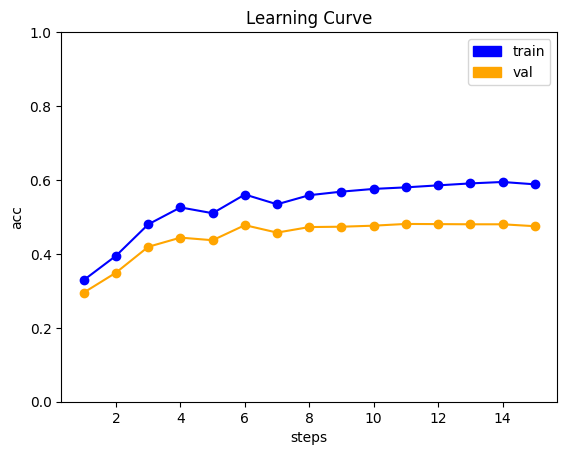

In [62]:
def plot_learning_curve(title, criterion, criterion_steps, performance_metric, performance_values_train, performance_values_val):
  """
  Plots a learning curve, i.e., the performance values for different values of a criterion.
  criterion_steps: the values of the points on the x-axis, e.g., step size, percentage of training data used, ...
  criterion: a string, used as label for the x-axis
  performance_metric: a string defining the performance metric, used as label for the y-axis
  performance_values_train: the values of the points on the y-axis, e.g., accuracy values for the x-values given in criterion_steps for the training set.
  performance_values_val: same as above but for the validation set.
  """

  plt.plot(criterion_steps, performance_values_train, linestyle='-', marker='o', color="blue")
  plt.plot(criterion_steps, performance_values_val, linestyle='-', marker='o', color="orange")

  plt.title(title)
  plt.xlabel(criterion)
  plt.ylabel(performance_metric)
  plt.ylim(0,1)

  p1 = mpatches.Patch(color='blue', label='train')
  p2 = mpatches.Patch(color='orange', label='val')
  plt.legend(handles=[p1, p2])

  plt.show()

print(len(steps), len(performance_values_train))
plot_learning_curve("Learning Curve", "steps", steps, "acc", performance_values_train, performance_values_val)

❓Plot a few different learning curves: (1) depending on the number of steps, (2) depending on a few different settings for the learning rate (when keeping all else constant), (3) depending on the size of the vocabulary. Add them as figures to your report. The captions should describe clearly what the plots show.


## Are you up for a challenge?

❓Improve the logistic regression classifier above and clearly (but briefly) describe your variations in your experimental report. Here are a few ideas to try:

* increase the number of epochs
* perform early stopping
* change the vocabulary / pick terms per class?
* use lemmas
* tune the learning_rate

### Evaluation

AFTER you have completed the hyperparameter tuning __using only the training and the validation set__, evaluate the final results.

❓In your experimental report, include a table reporting overall accuracy, and macro-average precision, recall, and F1 scores for several different settings (including the vanilla setting). Your table should clearly state which settings were used in a row. (Hint: You can use `\begin{table*} ... \end{table*}` to create wide tables in Latex.)

Optional: `pandas` provides some nice functions to turn tables into latex code.

In [ ]:
pred_labels = clf.predict(test_data_X)
print(pred_labels)

print(classification_report(test_data_y, pred_labels, digits=3))
for i, l in enumerate(labels):
  print(i, l)
